In [ ]:
import tulip as tlp
from tulip.interfaces import omega as omega_int
from tulip import transys, abstract, spec, synth
from visualization import graph_builder as gb
import networkx as nx
from tulip.transys import machines
from GR1_defaults import settings

from tulip import dumpsmach
import pickle

from omega.games import enumeration as enum

In [ ]:
path = 'Tgame/'

In [ ]:
# System definition
sys = tlp.transys.FTS()

sys.atomic_propositions.add_from({'a0', 'a1', 'a2', 'a3'})
sys.states.add('c0', ap={'a0'})
sys.states.add('c1', ap={'a1'})
sys.states.add('c2', ap={'a2'})
sys.states.add('c3', ap={'a3'})
sys.states.initial.add('c0')    # start in state c0

sys.transitions.add_comb({'c0'}, {'c0', 'c1'})
sys.transitions.add_comb({'c1'}, {'c1', 'c2'})
# sys.transitions.add_comb({'c1'}, {'c0', 'c1', 'c2'})
sys.transitions.add_comb({'c2'}, {'c2', 'c3'})
# sys.transitions.add_comb({'c2'}, {'c1', 'c2', 'c3'})
sys.transitions.add_comb({'c3'}, {'c3'})
# sys.transitions.add_comb({'c3'}, {'c2', 'c3'})

In [ ]:
# Variables
env_vars = {'b': (0, 4)}
sys_vars = {}

In [ ]:
# Initialization
env_init = {'b = 0'}
sys_init = {}

In [ ]:
# Safety
env_safe = {
    # Movement
    'b = 0 -> next(b) = 0 | next(b) = 1',
    'b = 1 -> next(b) = 1 | next(b) = 0 | next(b) = 2',
    'b = 2 -> next(b) = 2 | next(b) = 1 | next(b) = 3',
    'b = 3 -> next(b) = 3 | next(b) = 2 | next(b) = 4',
    'b = 4 -> next(b) = 4 | next(b) = 3',
}
sys_safe = {
    # No collision
    '!(a2 & b = 2)',
    # No being collided into
    # Commenting this out means that we are considering the game as having simultaneous updates
    '!(a2 & X(b = 2))'
}

In [ ]:
# Progress
env_prog = {'b = 4'}
sys_prog = {'a3'}
    

specs = settings.set_specs(env_vars, sys_vars, env_init, sys_init,
                        env_safe, sys_safe, env_prog, sys_prog)
print(specs.pretty())

spec = tlp.synth._spec_plus_sys(specs, None, sys, False, False)
# Automaton class found in omega/omega/symbolic/temporal.py
aut = omega_int._grspec_to_automaton(spec)

In [ ]:
# Synthesize the controller
ctrl = tlp.synth.synthesize(specs, sys=sys)
assert ctrl is not None, 'unrealizable'
with open(path + "ctrl", "wb") as file:
    pickle.dump(ctrl, file)

dumpsmach.write_python_case(path + 'controller.py', ctrl, classname="sys_ctrl")

In [ ]:
ctrl.plot()

In [ ]:
# spec = tlp.synth._spec_plus_sys(specs, None, sys, False, False)
# # Automaton class found in omega/omega/symbolic/temporal.py
# aut = omega_int._grspec_to_automaton(specs)

In [ ]:
# enum.action_to_steps(aut, env='env', sys='sys',qinit=aut.qinit)

In [ ]:
# enum.action_to_steps(aut, env='env', sys='sys')

In [ ]:
# enum.action_to_steps(aut, env='env', sys='impl')

In [ ]:
# Graphing
filename = path + "graph"
attributes = ['color', 'shape']

# Making a graph of the asynchronous GR(1) game with deadends.
g0 = gb.game_graph(aut, env='env', sys='sys', remove_deadends=False, append_non_visited=False, qinit=aut.qinit)
h0 = gb._game_format_nx(g0, attributes)
pd0 = nx.drawing.nx_pydot.to_pydot(h0)
pd0.write_pdf(path + 'game.pdf')
with open(filename, "wb") as file:
    pickle.dump(g0, file)

# Trying to satisfy the environment's liveness/progress conditions

## Find the nodes in the graph that satisfy any of the environment's progress conditions

In [ ]:
# making environment progress conditions into a dictionary
env_prog_dict = {}
for elem in env_prog:
    split_lst = elem.split(' = ')
    key = split_lst[0]
    if len(split_lst) == 1:
        env_prog_dict[key] = True
    elif type(env_vars[key]) == list:
        value = split_lst[1]
        env_prog_dict[key] = env_vars[key].index(value[1:len(value)-1])
    else:
        env_prog_dict[key] = int(split_lst[1])


In [ ]:
env_prog_dict

In [ ]:
# find the nodes in the graph that satisfy any of the environment's progress conditions
# each entry in the dictionary is a list of nodes that satisfying each progress condition
env_prog_nodes = {}
for item in env_prog_dict.items():
    env_prog_nodes[item] = []
for node in g0.nodes:
    for item in env_prog_dict.items():
        if item in g0.nodes[node].items():
            env_prog_nodes[item].append(node)

In [ ]:
env_prog_nodes

In [ ]:
for node in env_prog_nodes[('b', 4)]:
    print(g0.nodes[node])

In [ ]:
env_prog_nodes

## Find the cycles that contain nodes that satisfy each env progress condition

In [ ]:
# find all the simple cycles in g0
cycles = list(nx.simple_cycles(g0))

In [ ]:
cycles

In [ ]:
len(cycles)
# 28 cycles when runner cannot go backwards
# 1008 cycles when runner can go backwards

In [ ]:
g0.nodes[0]

In [ ]:
for cycle in cycles:
    cycle_nodes = ''
    for node in cycle:
        location = [g0.nodes[node]['b']]
        for key,val in g0.nodes[node].items():
            if type(val) == bool and val:
                location.append(key)
        cycle_nodes += str(location)
    print(cycle_nodes)
# it seems that almost everything can be a cycle because everyone can go backwards

In [ ]:
# make the cycles into frozensets (immutable sets)
old_cycles = set()
for cycle in cycles:
    old_cycles.add(frozenset(cycle))

# num_iters = 0
# while True:
#     num_iters += 1
#     new_cycles = old_cycles.copy()
#     for cycle in old_cycles:
#         for node in cycle:
#             for cycle2 in old_cycles:
#                 if node in cycle2:
#                     new_cycles.add(frozenset(cycle | cycle2))
#     print(old_cycles, new_cycles)
#     if new_cycles == old_cycles:
#         print(num_iters)
#         break
#     else:
#         old_cycles = new_cycles.copy()

# Combining simple cycles together and adding those to set of cycles
new_cycles = old_cycles.copy()
while True:
    for cycle1 in old_cycles:
        for cycle2 in old_cycles:
            # if not (cycle1.issubset(cycle2) or cycle2.issubset(cycle1)) and not cycle1.isdisjoint(cycle2):
            if cycle1 != cycle2:
                # get the intersection of the 2 nodes
                # get the environment nodes
                # loop over these nodes
                # loop over succesors of environment nodes
                # if one successor in cycle 1
                # and another successor in cycle 2
                # then add the union of the 2 cycles together
                cyc_intersection = cycle1.intersection(cycle2)
                env_intersection = [node for node in cyc_intersection if g0.nodes[node]['shape'] == 'oval']
                for env_node in env_intersection:
                    to_cycle1 = False
                    to_cycle2 = False
                    for succ in g0.successors(env_node):
                        if succ in cycle1:
                            to_cycle1 = True
                        elif succ in cycle2:
                            to_cycle2 = True
                        if to_cycle1 and to_cycle2:
                            break
                    if to_cycle1 and to_cycle2:
                            new_cycles.add(frozenset(cycle1.union(cycle2)))
                            break
    print(len(old_cycles), len(new_cycles))
    if new_cycles == old_cycles:
        break
    else:
        old_cycles = new_cycles.copy()

    

In [ ]:
# print("num_iters", num_iters)
# print("len(cycles)", len(cycles))
# print("len(new_cycles)", len(new_cycles))

In [ ]:
# to make the code work without having to change everything
cycles = new_cycles

In [ ]:
env_prog_nodes

In [ ]:
# Filter cycles that contain nodes that satisfy each type of progress condition
prog_satisfying_cycles = []
for cycle in cycles:
    satisfies_prog_counter = 0
    for lst in env_prog_nodes.values():
        for node in lst:
            if node in cycle:
                satisfies_prog_counter += 1
                break
    if satisfies_prog_counter == len(env_prog_dict.values()):
        prog_satisfying_cycles.append(cycle)

In [ ]:
prog_satisfying_cycles

## See if any of these cycles can have the system leave the cycle (with no return)

In [ ]:
g0.nodes[0]

In [ ]:
# see if any of these cycles can have the system leave the cycle (regardless of if it can return)
leave_counter = 0
num_cycles_left = 0
for cycle in prog_satisfying_cycles:
    cycle_left = False
    for node in cycle:
        # if g0.nodes[node]['shape'] != 'oval': 
        if g0.nodes[node]['shape'] == 'oval': 
            continue
        # node is a node from which the system takes the action
        for succ in g0.successors(node):
            if succ not in cycle:
                leave_counter += 1
                cycle_left = True
    if cycle_left:
        num_cycles_left += 1
print("leave_counter", leave_counter)
print("num_cycles_left", num_cycles_left)
print('num_cycles', len(prog_satisfying_cycles))

## Remove any cycles with the system leaving

In [ ]:
# This code is very similar to the code above. Fix this later
permanent_prog_cycles = []
for cycle in prog_satisfying_cycles:
    cycle_left = False
    for node in cycle:
        # if g0.nodes[node]['shape'] != 'oval':
        if g0.nodes[node]['shape'] == 'oval':
            continue
        # node is a node from which the system takes the action
        for succ in g0.successors(node):
            if succ not in cycle:
                leave_counter += 1
                cycle_left = True
    if cycle_left:
        num_cycles_left += 1
    else:
        permanent_prog_cycles.append(cycle)

In [ ]:
permanent_prog_cycles

In [ ]:
largest_cycles = []
for cycle in permanent_prog_cycles:
    is_subset = False
    for other_cycle in permanent_prog_cycles:
        if cycle != other_cycle and cycle.issubset(other_cycle):
            is_subset = True
            break
    if not is_subset:
        largest_cycles.append(cycle)

In [ ]:
largest_cycles

Do we acccount for the case where you enter one cycle then go into another via a path?
I do not think we do. 

Do we account for the case where multiple system actions can keep us within some cycle?
I also think no.

We only find cycles in which the system action cannot leave the cycle.

Need to fix.

## (Not necessary) Find all paths from the initial node to the cycles

In [ ]:
# def is_prefix(list1, list2):
#     # Compare the elements of both lists up to the length of the shorter list
#     min_length = min(len(list1), len(list2))
#     for i in range(min_length):
#         if list1[i] != list2[i]:
#             return False
#     return True

In [ ]:
# Find all the paths from the initial node(s) to the cycles satisfying the progress conditions
# ASSUMPTION: g0.nodes[0] is the ONLY initial node
# paths_to_cycle = []
# for cycle in prog_satisfying_cycles:
#     for node in cycle:
#         new_paths = list(nx.all_simple_paths(g0, 0, node))
#         # I do not want to have 2 paths, one of which is a subset of the other. 
#         # I just want the subset.
#         for new_path in new_paths[:]:
#             for existing_path in paths_to_cycle[:]:
#                 if is_prefix(new_path, existing_path):
#                     if len(new_path) < len(existing_path):
#                         paths_to_cycle.remove(existing_path)
#                     else:
#                         new_paths.remove(new_path)
#                         break
#         paths_to_cycle += new_paths

new problem: This does not take into account that the system may take some action 
that will take us away from one of these paths. Do we have to care?
Yes. We want to always satisfy the liveness conditions, no matter what the system does.

Should I do some winning set calculations? I can't just use the winning set 
functions because I want to use the GR1 graph that contains the actions the 
system can take that satisfy its winning condition. 

Okay let's say that there is a safe action that the system can take but will lead to
the environment taking the system to a red node. Is that in our graph? No... it does not seem so.
Wouldn't we want a hard test to find this case? Do we just assume that the system has failed at this point?

okay so should we just assume the graph is ideal
and then figure out the paths that allow the environment to satisfy its progress conditions,
regardless of what the system does

In [ ]:
# len(paths_to_cycle)

In [ ]:
# paths_to_cycle

Should I make a graph that adds a transition from one env node to another only if all system actions from 
the env node go to the other

Then, I do the same code on this

Wait, I should do it on sets. Only if all system actions from the env node go to a winning set lol


## Find the "levels" that lead to the environment progress cycles

In [ ]:
# getting the nodes in the cycles that satisfy the env progress conditions
nodes_satisfying_prog = set()
# for lst in prog_satisfying_cycles:
for lst in largest_cycles:
    nodes_satisfying_prog |= set(lst)

In [ ]:
nodes_satisfying_prog

In [ ]:
# calculate the "levels" from the env prog cycle outwards
R = {}
i = 0
R[i] = nodes_satisfying_prog
while True:
    new_nodes = set()
    for node in R[i]:
        new_nodes |= set(g0.predecessors(node))
    R[i+1] = new_nodes | R[i]

    new_nodes = set()
    for node in R[i+1]:
        for prev in set(g0.predecessors(node)):
            all_transitions_to_Ri1 = True
            for trans in set(g0.successors(prev)):
                if trans not in R[i+1]:
                    all_transitions_to_Ri1 = False
                    break
            if all_transitions_to_Ri1:
                new_nodes.add(prev)
    R[i+2] = new_nodes | R[i+1]

    if R[i+2] == R[i]:
        R.pop(i+2)
        R.pop(i+1)
        break
    else:
        i += 2

In [ ]:
# the initial state is in the largest "level" out of the env prog cycle
# i.e. there is a path for the environment to the progress satisfying cycles,
# regardless of the moves the system takes
# ASSUMPTION the initial state is ONLY node 0
0 in R[len(R)-1]

# Start from initial state(s?) and go to the union of cycles

In [ ]:
def go_to_cycles(robustness, R, g):
    

In [ ]:
??nx.simple_cycles

In [ ]:
nx.__version__

In [ ]:
import sys
!{sys.executable} -m pip install --upgrade networkx

In [ ]:
!{sys.executable} -m pip install --upgrade pip

In [ ]:
import sys
print(sys.version)

In [ ]:
{1,2,3}.issubset({1,2})

In [ ]:
{1,2}.issubset({1,2,3})

In [ ]:
{1,2,3}.issubset({1,2,3})

In [ ]:
a = {frozenset({1,2}),frozenset({4,2})}
b = a.copy()

In [ ]:
b.remove(frozenset({1,2}))

In [ ]:
b

In [ ]:
b.remove(frozenset({1,2}))

In [ ]:
{1,2,3}.intersection({4,2,3})

In [1]:
import pickle

In [2]:
et_file = '/Users/kimiahassibi/Desktop/Caltech/SURF2023/GR1_simulations/left_turn_pedestrian/elapsed_times'
with open(et_file, 'rb') as pickle_file:
    elapsed_times = pickle.load(pickle_file)
elapsed_times

[0.04036402702331543,
 0.03708600997924805,
 0.04718899726867676,
 0.04001212120056152,
 0.036047935485839844,
 0.0340580940246582,
 0.03499293327331543,
 0.03386998176574707,
 0.03359222412109375,
 0.044996023178100586,
 0.03397083282470703,
 0.03648495674133301,
 0.04071664810180664,
 0.03881216049194336,
 0.03934526443481445]

In [3]:
cut_file = '/Users/kimiahassibi/Desktop/Caltech/SURF2023/GR1_simulations/left_turn_pedestrian/cut_off_early'
with open(cut_file, 'rb') as pickle_file:
    cutt_off_early = pickle.load(pickle_file)
cutt_off_early

[True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True]

In [4]:
import matplotlib.pyplot as plt

In [5]:
penalties = [-1, 0, 0.25, 0.5, 1, 1.5, 2, 2.5, 3, 3.5, 4, 4.5, 5, 10, 100]

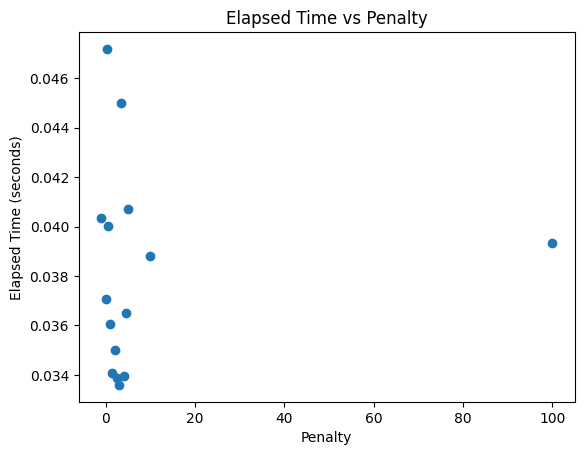

In [7]:

# Create the scatter plot
plt.scatter(penalties, elapsed_times)

# Add title and labels
plt.title('Elapsed Time vs Penalty')
plt.xlabel('Penalty')
plt.ylabel('Elapsed Time (seconds)')

# Show the plot
plt.show()